In [1]:
!pip install SpeechRecognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 21.3 MB/s eta 0:00:00


In [2]:
!pip install gTTS

In [3]:
# import the necessary packages
import sys
import numpy as np
import argparse
import time
import cv2
import os
import speech_recognition as sr
from gtts import gTTS

In [4]:
!wget https://github.com/AlexeyAB/darknet/raw/master/data/coco.names -O /content/coco.names

--2024-03-26 20:16:39--  https://github.com/AlexeyAB/darknet/raw/master/data/coco.names
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AlexeyAB/darknet/master/data/coco.names [following]
--2024-03-26 20:16:40--  https://raw.githubusercontent.com/AlexeyAB/darknet/master/data/coco.names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625 [text/plain]
Saving to: ‘/content/coco.names’

/content/coco.names 100%[===================>]     625  --.-KB/s    in 0s      

2024-03-26 20:16:40 (48.0 MB/s) - ‘/content/coco.names’ saved [625/625]



In [5]:
#construct the argument parse and parse the arguments

import argparse

ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=False, default="/content/image.jpg", help="path to input image")
ap.add_argument("-y", "--yolo", required=False, default="/content/", help="base path to YOLO directory")
ap.add_argument("-c", "--confidence", type=float, default=0.5, help="minimum probability to filter weak detections")
ap.add_argument("-t", "--threshold", type=float, default=0.3, help="threshold when applying non-maxima suppression")
args = vars(ap.parse_args([]))  # Note the empty list passed to parse_args



In [6]:
# load COCO class labels to YOLO model
labelsPath = os.path.sep.join([args["yolo"], "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")

In [7]:
#initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),dtype="uint8")

In [8]:
!wget https://pjreddie.com/media/files/yolov3.weights -O /content/yolov3.weights

--2024-03-26 20:16:54--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘/content/yolov3.weights’

/content/yolov3.wei 100%[===================>] 236.52M  41.4MB/s    in 6.0s    

2024-03-26 20:17:01 (39.2 MB/s) - ‘/content/yolov3.weights’ saved [248007048/248007048]



In [9]:
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg -O yolov3.cfg


--2024-03-26 20:17:05--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2024-03-26 20:17:05 (38.4 MB/s) - ‘yolov3.cfg’ saved [8342/8342]



In [10]:
# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join([args["yolo"], "yolov3.weights"])
configPath = os.path.sep.join([args["yolo"], "yolov3.cfg"])

In [11]:
# load YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)


[INFO] loading YOLO from disk...


In [12]:
import os

print(os.path.exists(args["image"]))  # This should print True if the file exists


False


In [16]:
# load input image and grab the spatial dimensions
image = cv2.imread(args["image"])
if image is None:
    print(f"Failed to load image at {args['image']}. Please check the path.")
else:
    (H, W) = image.shape[:2]
    print("Image loaded successfully.")


Image loaded successfully.


In [17]:
# Determine only the output layer names that we need from YOLO
ln = net.getLayerNames()
out_layer_indices = net.getUnconnectedOutLayers()

# Adjust for the possibility of 'getUnconnectedOutLayers' returning a flat array or a multi-dimensional one
if len(out_layer_indices.shape) == 2:  # Multi-dimensional array, likely scenario in newer OpenCV versions
    ln = [ln[i[0] - 1] for i in out_layer_indices]
else:  # Flat array, possible in older versions or specific OpenCV builds
    ln = [ln[i - 1] for i in out_layer_indices]


In [18]:
'''
construct a blob from the input image and then perform a forward pass of the YOLO object detector
giving us the bounding box and associated probabilities
'''
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()


In [19]:
# show timing information on YOLO
print("[INFO] YOLO took {:.6f} seconds".format(end - start))


[INFO] YOLO took 2.778556 seconds


In [20]:
# initialize lists of detected bounding boxes, confidences, and class IDs, respectively
boxes = []
confidences = []
classIDs = []
ID = 0

In [21]:
# loop over each of the layer outputs
for output in layerOutputs:
  for detection in output:
    # extract the class IDs and confidence of the current object detection
    scores = detection[5:]
    classID = np.argmax(scores)
    confidence = scores[classID]
    # filter out weak predictions by ensuring the detected probability is greater
    # than the minimum probability
    if confidence > args["confidence"]:
      # scale the bounding box coordinates back relative to the size of the
      # image, keeping in mind that YOLO actually returns the center (x, y)
      # coordinates of the bounding box followed by the boxes width and height
      box = detection[0:4] * np.array([W, H, W, H])
      (centerX, centerY, width, height) = box.astype("int")

      # use the center (x, y) coordinate to derive the top and the left corner of
      # the bounding box
      x = int(centerX - (width / 2))
      y = int(centerY - (height / 2))
      # update our list of bounding box coordinates, confidences, and class IDs
      boxes.append([x, y, int(width), int(height)])
      confidences.append(float(confidence))
      classIDs.append(classID)


In [22]:
# apply non-maxima suppression to suppress weak, overlapping bounding boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, args["confidence"], args["threshold"])

In [23]:
# Draw the bounding boxes on the image
for i in idxs.flatten():
    (x, y) = (boxes[i][0], boxes[i][1])
    (w, h) = (boxes[i][2], boxes[i][3])
    color = [int(c) for c in COLORS[classIDs[i]]]
    cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
    text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
    cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


In [24]:
#ensure atleast one detection exists
if len(idxs) > 0:
  list1 = []
  for i in idxs.flatten():
  # extract bounding box coordinates
    (x, y) = (boxes[i][0], boxes[i][1])
    (w, h) = (boxes[i][2], boxes[i][3])
    centerx = round((2*x + w)/2)
    centery = round((2*y + h)/2)
    if centerX <= W/3:
      W_pos = "left "
    elif centerX <= (W/3 * 2):
      W_pos = "center "
    else:
      W_pos = "right "

    if centerY <= H/3:
      H_pos = "top "
    elif centerY <= (H/3 * 2):
      H_pos = "mid "
    else:
      H_pos = "bottom "
    list1.append(H_pos + W_pos + LABELS[classIDs[i]])

description = ', '.join(list1)

In [25]:
# convert text output into speech using the google text to speech api
myobj = gTTS(text=description, lang="en", slow=False)
myobj.save("object_detection.mp3")


In [26]:
cv2.imwrite("output.jpg", image)

True

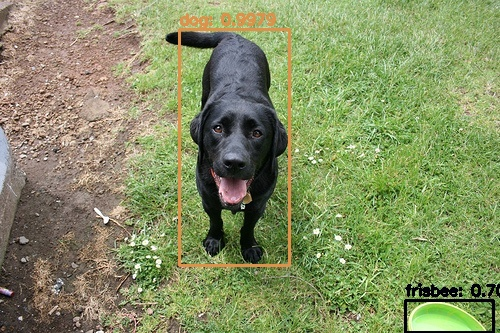

In [27]:
from IPython.display import Image
Image(filename="output.jpg")


In [28]:

from IPython.display import Audio

# Create the gTTS object
myobj = gTTS(text=description, lang="en", slow=False)

# Save the speech to a temporary file
temp_file = "/content/temp_object_detection.mp3"
myobj.save(temp_file)

# Play the audio directly in Colab
Audio(temp_file, autoplay=True)


In [30]:
import cv2
import numpy as np
import requests  # Make sure to import requests
from gtts import gTTS
from IPython.display import Audio, Image, display
import os
def detect_and_describe(url, yolo_base_path="/content/"):
    # Import statements and initial setup...
    import numpy as np
    import cv2
    import requests
    from IPython.display import Image, display, Audio
    from gtts import gTTS

    response = requests.get(url)
    image_array = np.asarray(bytearray(response.content), dtype="uint8")
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    if image is None:
        print("Failed to load image from URL.")
        return

    labelsPath = os.path.join(yolo_base_path, "coco.names")
    LABELS = open(labelsPath).read().strip().split("\n")
    COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

    weightsPath = os.path.join(yolo_base_path, "yolov3.weights")
    configPath = os.path.join(yolo_base_path, "yolov3.cfg")
    net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

    (H, W) = image.shape[:2]
    ln = net.getLayerNames()
    try:
        out_layers = net.getUnconnectedOutLayers()
        if out_layers.ndim == 2 and out_layers.shape[1] == 1:  # Newer OpenCV versions
            out_layer_indices = out_layers[:, 0]
        else:
            out_layer_indices = out_layers
        ln = [ln[i - 1] for i in out_layer_indices.flatten()]
    except AttributeError:  # Fallback for older OpenCV versions
        ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)

    boxes = []
    confidences = []
    classIDs = []

    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > 0.5:
                box = detection[0:4] * np.array([W, H, W, H])
                centerX, centerY, width, height = box.astype("int")

                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)

    if len(idxs) > 0:
        for i in idxs.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            color = [int(c) for c in COLORS[classIDs[i]]]
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.2f}".format(LABELS[classIDs[i]], confidences[i])
            cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Save and display the image
    output_image_path = "output.jpg"
    cv2.imwrite(output_image_path, image)
    display(Image(filename=output_image_path))

    # Optionally, generate a description and convert it to speech (omitted for brevity)
    # Generating a description
    detected_items = [LABELS[i] for i in classIDs]
    description = "Detected objects: " + ", ".join(set(detected_items))
    print(description)

    # Converting description to speech
    tts = gTTS(text=description, lang="en", slow=False)
    speech_path = "description.mp3"
    tts.save(speech_path)

    # Playing the audio in the notebook
    display(Audio(speech_path, autoplay=True))


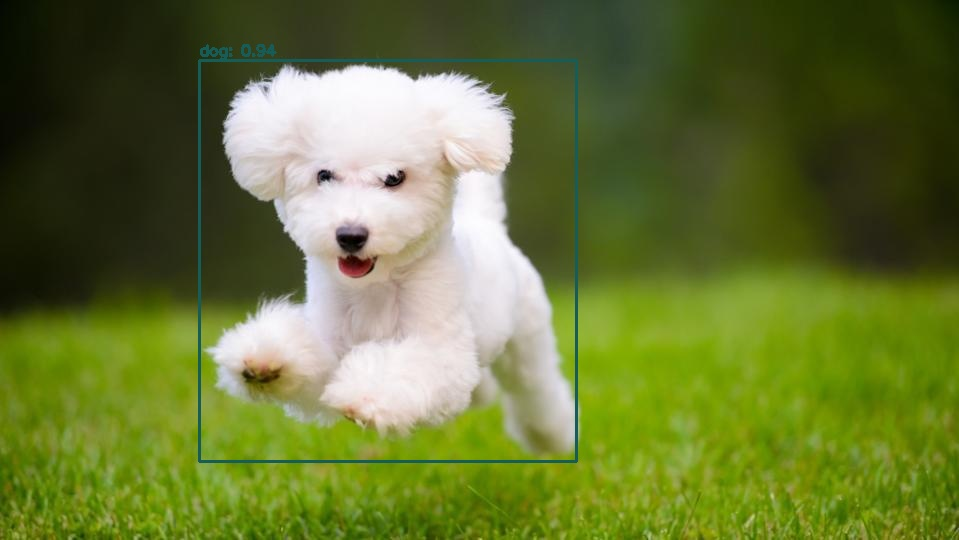

Detected objects: dog


In [31]:
# Example of calling the function
url = "https://www.forbes.com/advisor/wp-content/uploads/2023/07/top-20-small-dog-breeds.jpeg.jpg"  # Replace with your actual image URL
detect_and_describe(url)


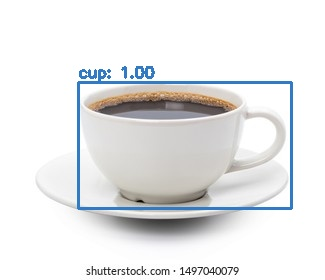

Detected objects: diningtable, cup


In [32]:
# Example of calling the function
url = "https://www.shutterstock.com/image-photo/white-cup-black-coffee-isolated-260nw-1497040079.jpg"  # Replace with your actual image URL
detect_and_describe(url)


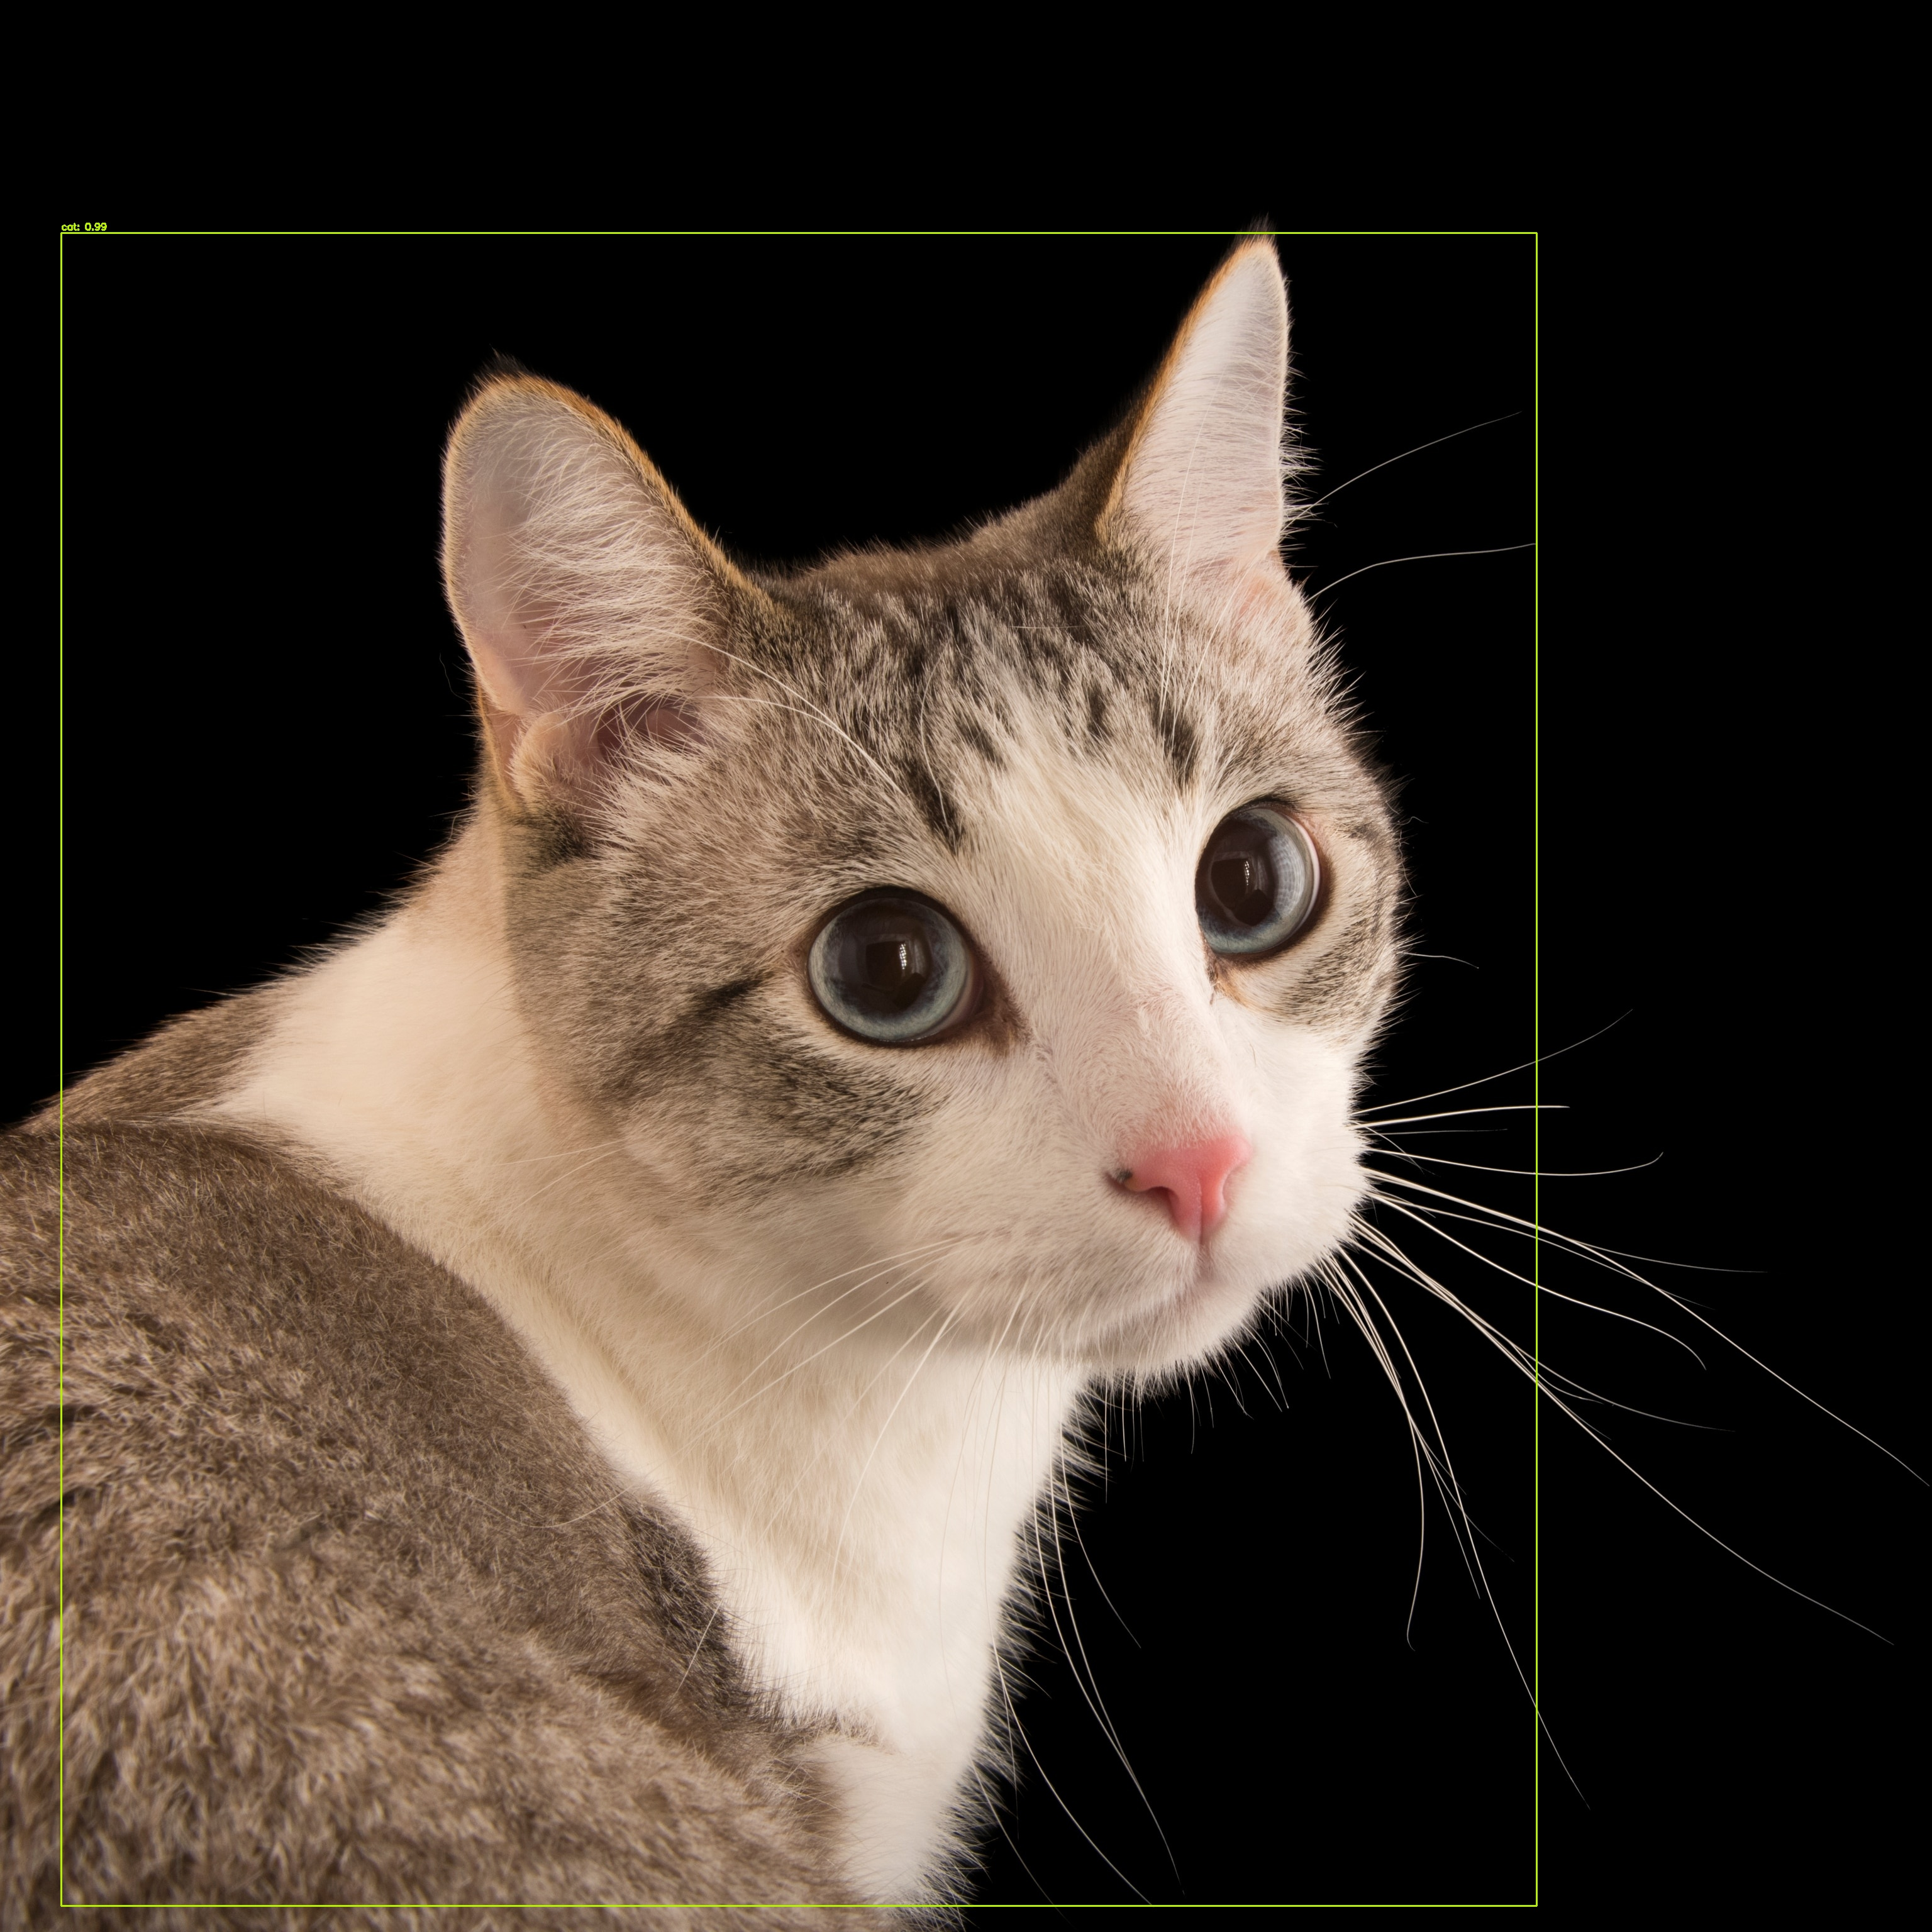

Detected objects: cat


In [33]:
# Example of calling the function
url = "https://i.natgeofe.com/n/548467d8-c5f1-4551-9f58-6817a8d2c45e/NationalGeographic_2572187_square.jpg"  # Replace with your actual image URL
detect_and_describe(url)


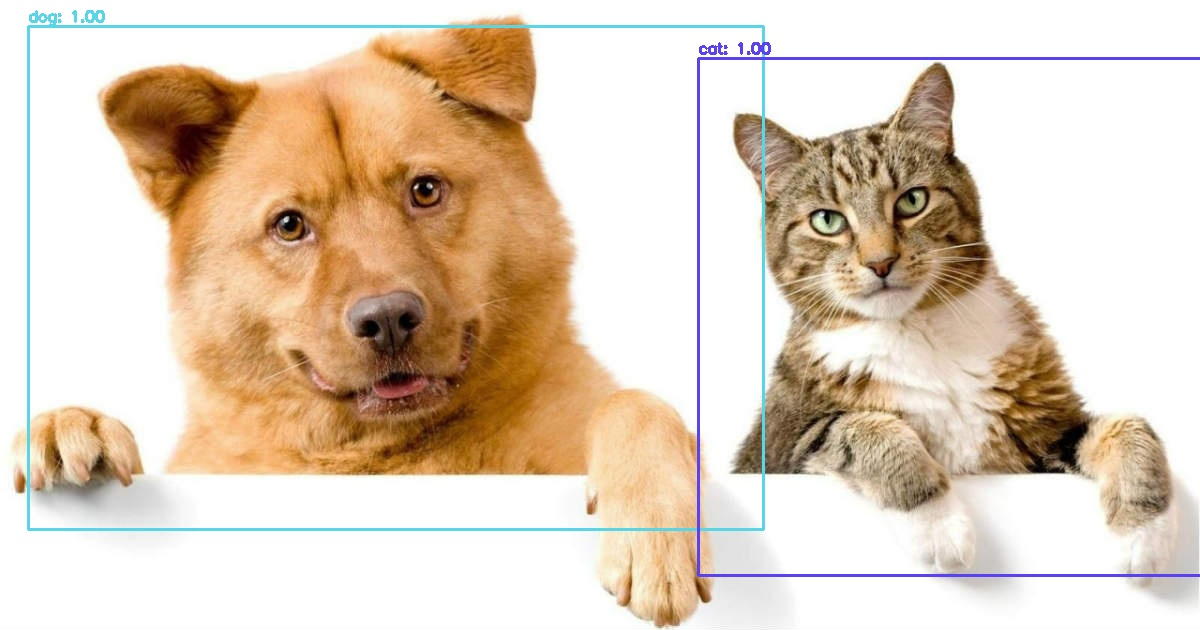

Detected objects: dog, cat


In [34]:
# Example of calling the function
url = "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg"  # Replace with your actual image URL
detect_and_describe(url)


In [ ]:
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
!tar xf VOCtrainval_06-Nov-2007.tar
import os
import random
import shutil
import xml.etree.ElementTree as ET

# Path to the Pascal VOC 2007 dataset directory
dataset_dir = "VOCdevkit/VOC2007"

# Directory to save the randomly selected images
output_dir = "random_images"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# List all files in the dataset's JPEGImages directory
image_files = os.listdir(os.path.join(dataset_dir, "JPEGImages"))

# Randomly select 50 images
selected_images = random.sample(image_files, 50)

# Copy selected images to the output directory
for image_file in selected_images:
    src_path = os.path.join(dataset_dir, "JPEGImages", image_file)
    dst_path = os.path.join(output_dir, image_file)
    shutil.copy(src_path, dst_path)

# Now you have 50 randomly selected images in the 'random_images' directory.
# Next, you need to read the annotations to obtain the true labels.

true_labels = {}

# Read annotations and associate them with the corresponding images
for image_file in selected_images:
    annotation_file = os.path.join(dataset_dir, "Annotations", image_file.replace(".jpg", ".xml"))

    # Parse XML file
    tree = ET.parse(annotation_file)
    root = tree.getroot()

    # Extract bounding box coordinates and labels
    labels = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        labels.append(label)

    # Store labels for the image
    true_labels[image_file] = labels

# Now 'true_labels' dictionary contains the true labels for each randomly selected image.
# You can use these true labels to compare with the predictions of your object detection model.

--2024-03-26 19:45:47--  http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar [following]
--2024-03-26 19:45:48--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  9.52MB/s    in 37s     

2024-03-26 19:46:25 (11.9 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]



                precision    recall  f1-score   support

        person       0.59      0.64      0.61        47
       bicycle       1.00      0.75      0.86         4
           car       0.65      0.54      0.59        24
     motorbike       0.33      0.20      0.25         5
     aeroplane       1.00      0.50      0.67         2
           bus       0.50      0.25      0.33         4
         train       1.00      1.00      1.00         1
         truck       0.00      0.00      0.00         0
          boat       0.67      0.57      0.62         7
 traffic light       0.00      0.00      0.00         0
  fire hydrant       0.00      0.00      0.00         0
     stop sign       0.00      0.00      0.00         0
 parking meter       0.00      0.00      0.00         0
         bench       0.00      0.00      0.00         0
          bird       1.00      1.00      1.00         1
           cat       1.00      1.00      1.00         2
           dog       1.00      1.00      1.00  

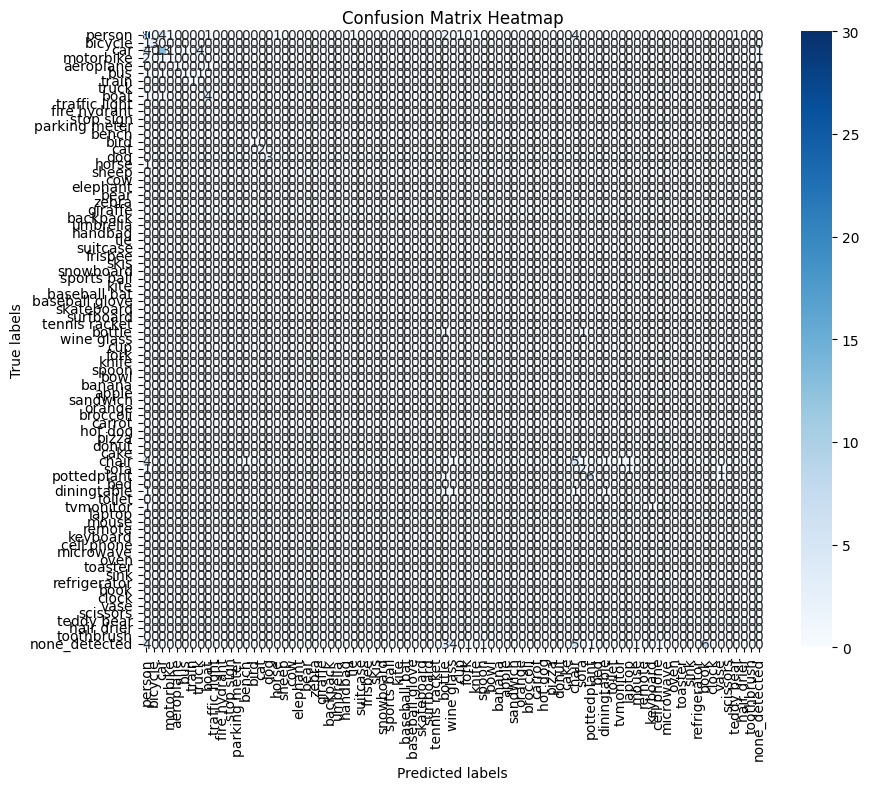

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from collections import Counter
import os

# Assuming these variables are defined and initialized as per your setup:
dataset_dir = "VOCdevkit/VOC2007"
output_dir = "random_images"
config_path = 'yolov3.cfg'
weights_path = '/content/yolov3.weights'
LABELS = [label.strip() for label in open('/content/coco.names').readlines()]

def load_yolo_model(configPath, weightsPath):
    """
    Load YOLO model from the given configuration and weights.
    """
    net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)  # Use DNN_TARGET_CUDA for GPU
    return net

def get_outputs_names(net):
    """
    Get the names of the output layers of the YOLO network.
    """
    layers_names = net.getLayerNames()
    out_layers = net.getUnconnectedOutLayers().flatten()  # Fix for handling different OpenCV versions
    return [layers_names[i - 1] for i in out_layers]

def post_process(image, outs, confidence_threshold, threshold):
    """
    Remove the bounding boxes with low confidence and apply non-max suppression.
    """
    frame_height = image.shape[0]
    frame_width = image.shape[1]

    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > confidence_threshold:
                center_x = int(detection[0] * frame_width)
                center_y = int(detection[1] * frame_height)
                width = int(detection[2] * frame_width)
                height = int(detection[3] * frame_height)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)

                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Apply non-max suppression
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, threshold)

    detected_classes = []
    if indices is not None and len(indices) > 0:
        # Correctly handle different structures of `indices`
        for i in indices:
            if isinstance(i, tuple) or isinstance(i, list) and len(i) > 0:
                detected_class_id = i[0]
            else:
                detected_class_id = i
            detected_classes.append(class_ids[detected_class_id])

    return detected_classes



# Definitions for `run_yolo_evaluation` and `evaluate_model_on_voc` remain unchanged

# Call the function with your initialized variables
# evaluate_model_on_voc(dataset_dir, output_dir, true_labels, LABELS, config_path, weights_path)
def run_yolo_evaluation(images_dir, true_labels, LABELS, config_path, weights_path, confidence=0.5, threshold=0.3):
    # Load the YOLO model
    net = load_yolo_model(config_path, weights_path)
    predicted_labels = {}

    for img_file, true_labels_list in true_labels.items():
        image_path = os.path.join(images_dir, img_file)
        image = cv2.imread(image_path)

        blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
        net.setInput(blob)
        outs = net.forward(get_outputs_names(net))

        detected_class_indices = post_process(image, outs, confidence, threshold)
        detected_labels = [LABELS[class_id] for class_id in detected_class_indices]

        predicted_labels[img_file] = detected_labels

    return predicted_labels

def evaluate_model_on_voc(dataset_dir, output_dir, true_labels, LABELS, config_path, weights_path):
    predicted_labels = run_yolo_evaluation(output_dir, true_labels, LABELS, config_path, weights_path)

    # Ensure each image contributes to the evaluation
    all_trues = []
    all_preds = []

    # Loop through each image
    for img_file, true_labels_list in true_labels.items():
        # Predicted labels for the image
        preds_for_img = predicted_labels.get(img_file, [])

        # Ensure there's a label for comparison even if no objects were detected
        if not preds_for_img:
            preds_for_img = ["none_detected"]

        # Add predicted and true labels for the image to the lists
        all_preds.extend(preds_for_img)

        # Match the number of true labels to the number of predictions by repeating or using placeholders
        matched_true_labels = true_labels_list if len(true_labels_list) >= len(preds_for_img) else true_labels_list + ["none_detected"] * (len(preds_for_img) - len(true_labels_list))
        all_trues.extend(matched_true_labels[:len(preds_for_img)])  # Ensure the true labels list matches the preds list length for the image

    # Adjust LABELS to include the placeholder if not already included
    adjusted_labels = LABELS + ["none_detected"] if "none_detected" not in LABELS else LABELS

    # Calculate and print classification metrics
    print(classification_report(all_trues, all_preds, labels=adjusted_labels, zero_division=0, target_names=adjusted_labels))

    # Construct and plot confusion matrix
    cm = confusion_matrix(all_trues, all_preds, labels=adjusted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=adjusted_labels, yticklabels=adjusted_labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix Heatmap')
    plt.show()


# Now, call the function with your initialized variables
evaluate_model_on_voc(dataset_dir, output_dir, true_labels, LABELS, config_path, weights_path)




                precision    recall  f1-score   support

        person       0.59      0.64      0.61        47
       bicycle       1.00      0.75      0.86         4
           car       0.65      0.54      0.59        24
     motorbike       0.33      0.20      0.25         5
     aeroplane       1.00      0.50      0.67         2
           bus       0.50      0.25      0.33         4
         train       1.00      1.00      1.00         1
         truck       0.00      0.00      0.00         0
          boat       0.67      0.57      0.62         7
 traffic light       0.00      0.00      0.00         0
  fire hydrant       0.00      0.00      0.00         0
     stop sign       0.00      0.00      0.00         0
 parking meter       0.00      0.00      0.00         0
         bench       0.00      0.00      0.00         0
          bird       1.00      1.00      1.00         1
           cat       1.00      1.00      1.00         2
           dog       1.00      1.00      1.00  

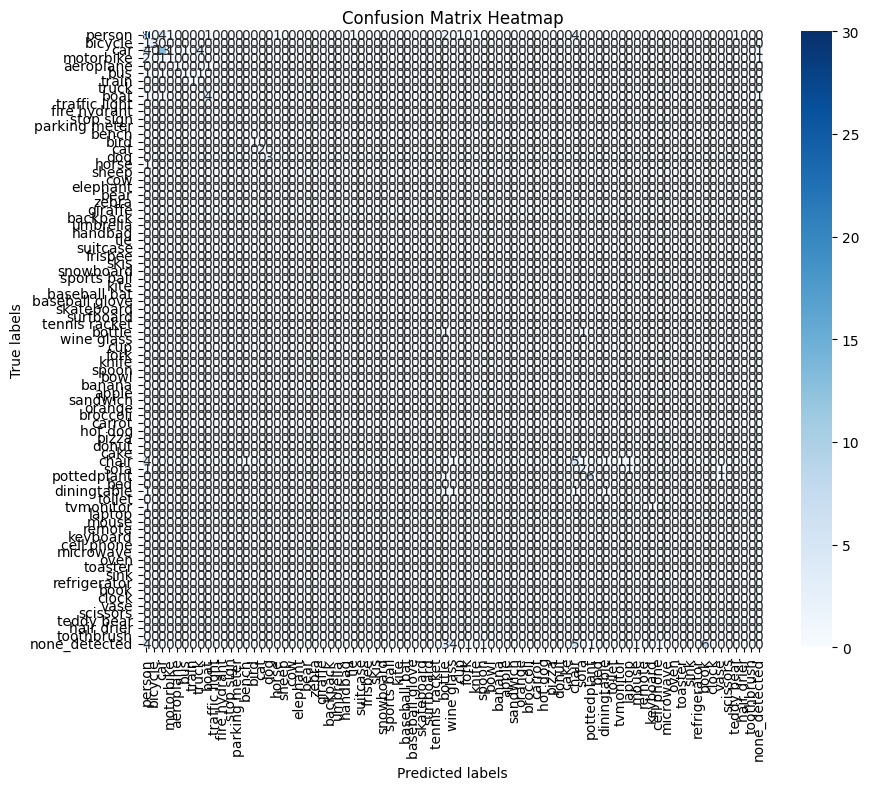

In [ ]:
%matplotlib inline
evaluate_model_on_voc(dataset_dir, output_dir, true_labels, LABELS, config_path, weights_path)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model_on_voc2(dataset_dir, output_dir, true_labels, LABELS, config_path, weights_path):
    predicted_labels = run_yolo_evaluation(output_dir, true_labels, LABELS, config_path, weights_path)

    # Initialize counts for true/false positives/negatives
    tp = 0  # True Positives
    fp = 0  # False Positives
    fn = 0  # False Negatives
    tn = 0  # True Negatives - In this context, it might not be applicable

    # Loop through each image
    for img_file, true_labels_list in true_labels.items():
        preds_for_img = predicted_labels.get(img_file, [])

        if true_labels_list:  # If there are objects in the ground truth
            if preds_for_img:
                tp += 1  # Correctly detected objects
                fp += len(preds_for_img) - 1  # Additional detections are considered false positives
                fn += len(true_labels_list) - 1  # Missed detections are considered false negatives
            else:
                fn += 1  # No detections, but objects are present
        else:
            if preds_for_img:
                fp += 1  # Objects detected, but none are actually present
            else:
                tn += 1  # Nothing detected, nothing present

    # Simplified 2x2 confusion matrix
    simple_cm = np.array([[tp, fp], [fn, tn]])

    # Calculate and print classification metrics (This will be the full multi-class report)
    print(classification_report(all_trues, all_preds, labels=adjusted_labels, zero_division=0, target_names=adjusted_labels))

    # Plotting the simplified confusion matrix
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(simple_cm, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(simple_cm.shape[0]):
        for j in range(simple_cm.shape[1]):
            ax.text(x=j, y=i, s=simple_cm[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.title('Simplified Confusion Matrix')
    plt.xticks([0, 1], ['Positive (Detected)', 'Negative (Not Detected)'])
    plt.yticks([0, 1], ['Positive (True)', 'Negative (False)'])
    plt.show()

# Assuming run_yolo_evaluation, true_labels, LABELS, config_path, and weights_path are defined correctly
evaluate_model_on_voc2(dataset_dir, output_dir, true_labels, LABELS, config_path, weights_path)


NameError: name 'all_trues' is not defined

                precision    recall  f1-score   support

        person       0.59      0.64      0.61        47
       bicycle       1.00      0.75      0.86         4
           car       0.65      0.54      0.59        24
     motorbike       0.33      0.20      0.25         5
     aeroplane       1.00      0.50      0.67         2
           bus       0.50      0.25      0.33         4
         train       1.00      1.00      1.00         1
         truck       0.00      0.00      0.00         0
          boat       0.67      0.57      0.62         7
 traffic light       0.00      0.00      0.00         0
  fire hydrant       0.00      0.00      0.00         0
     stop sign       0.00      0.00      0.00         0
 parking meter       0.00      0.00      0.00         0
         bench       0.00      0.00      0.00         0
          bird       1.00      1.00      1.00         1
           cat       1.00      1.00      1.00         2
           dog       1.00      1.00      1.00  

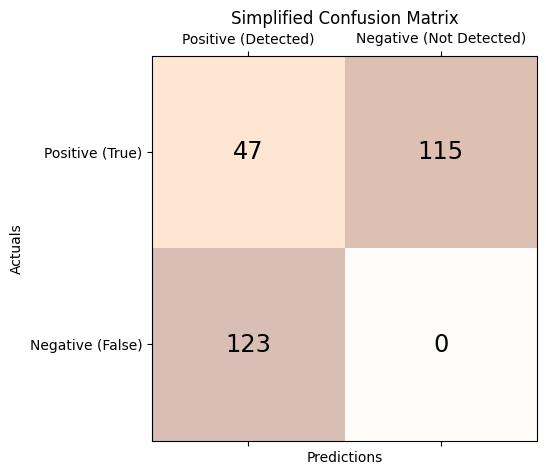

In [ ]:
def evaluate_model_on_voc2(dataset_dir, output_dir, true_labels, LABELS, config_path, weights_path):
    predicted_labels = run_yolo_evaluation(output_dir, true_labels, LABELS, config_path, weights_path)

    # Ensure each image contributes to the evaluation
    all_trues = []
    all_preds = []

    # Loop through each image
    for img_file, true_labels_list in true_labels.items():
        # Predicted labels for the image
        preds_for_img = predicted_labels.get(img_file, [])

        # Ensure there's a label for comparison even if no objects were detected
        if not preds_for_img:
            preds_for_img = ["none_detected"]

        # Add predicted and true labels for the image to the lists
        all_preds.extend(preds_for_img)

        # Match the number of true labels to the number of predictions by repeating or using placeholders
        matched_true_labels = true_labels_list if len(true_labels_list) >= len(preds_for_img) else true_labels_list + ["none_detected"] * (len(preds_for_img) - len(true_labels_list))
        all_trues.extend(matched_true_labels[:len(preds_for_img)])  # Ensure the true labels list matches the preds list length for the image

    # Adjust LABELS to include the placeholder if not already included
    adjusted_labels = LABELS + ["none_detected"] if "none_detected" not in LABELS else LABELS

    # Calculate and print classification metrics
    print(classification_report(all_trues, all_preds, labels=adjusted_labels, zero_division=0, target_names=adjusted_labels))

     # Initialize counts for true/false positives/negatives
    tp = 0  # True Positives
    fp = 0  # False Positives
    fn = 0  # False Negatives
    tn = 0  # True Negatives - In this context, it might not be applicable

    # Loop through each image
    for img_file, true_labels_list in true_labels.items():
        preds_for_img = predicted_labels.get(img_file, [])

        if true_labels_list:  # If there are objects in the ground truth
            if preds_for_img:
                tp += 1  # Correctly detected objects
                fp += len(preds_for_img) - 1  # Additional detections are considered false positives
                fn += len(true_labels_list) - 1  # Missed detections are considered false negatives
            else:
                fn += 1  # No detections, but objects are present
        else:
            if preds_for_img:
                fp += 1  # Objects detected, but none are actually present
            else:
                tn += 1  # Nothing detected, nothing present

    # Simplified 2x2 confusion matrix
    simple_cm = np.array([[tp, fp], [fn, tn]])

      # Calculate and print classification metrics (This will be the full multi-class report)
    print(classification_report(all_trues, all_preds, labels=adjusted_labels, zero_division=0, target_names=adjusted_labels))

    # Plotting the simplified confusion matrix
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(simple_cm, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(simple_cm.shape[0]):
        for j in range(simple_cm.shape[1]):
            ax.text(x=j, y=i, s=simple_cm[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.title('Simplified Confusion Matrix')
    plt.xticks([0, 1], ['Positive (Detected)', 'Negative (Not Detected)'])
    plt.yticks([0, 1], ['Positive (True)', 'Negative (False)'])
    plt.show()


# Now, call the function with your initialized variables
evaluate_model_on_voc2(dataset_dir, output_dir, true_labels, LABELS, config_path, weights_path)




In [76]:
! pip install streamlit -q
!wget -q -O - ipv4.icanhazip.com

34.70.126.246


In [63]:
! pip install gtts -q

In [77]:
%%writefile app.py
import streamlit as st
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import cv2
from gtts import gTTS
import os
from finalobject_od import detect_and_describe


# Assuming the following function exists in your provided notebook:
# from your_module import detect_and_draw

# Function to download image from URL
def load_image_from_url(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    return image

# Streamlit app
st.title("Object Detection App")

# Image uploader
uploaded_file = st.file_uploader("Upload an image...", type=["jpg", "jpeg", "png"])
image_url = st.text_input("...or enter an Image URL")

# Function to convert PIL image to OpenCV format
def pil_to_cv(image):
    return cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

# Detect button
if st.button('Detect'):
    if uploaded_file is not None or image_url:
        # Load the image from uploader or URL
        if uploaded_file is not None:
            image = Image.open(uploaded_file)
        else:
            image = load_image_from_url(image_url)

        # Convert PIL image to OpenCV format
        cv_image = pil_to_cv(image)

        # Call object detection function (placeholder)
        detect_and_describe(image_url, yolo_base_path="/content/")

    else:
        st.warning("Please upload an image or enter an image URL.")


Overwriting app.py


In [71]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
updated 1 package and audited 36 packages in 1.306s

3 packages are looking for funding
  run `npm fund` for details

found 2 moderate severity vulnerabilities
  run `npm audit fix` to fix them, or `npm audit` for details


In [78]:
!streamlit run /content/app.py &>/content/logs.txt &


In [ ]:
!npx localtunnel --port 8501

npx: installed 22 in 2.274s
your url is: https://nine-onions-judge.loca.lt


In [ ]:
# Assuming detect_and_draw function returns the image with boxes and the description
        image_with_boxes, description = detect_and_draw(cv_image)

        # Convert back to PIL image and display
        st.image(image_with_boxes, caption='Detected Objects', use_column_width=True)

        # Google Text-to-Speech
        tts = gTTS(description, lang='en')
        tts.save('detections.mp3')
        audio_file = open('detections.mp3', 'rb')
        audio_bytes = audio_file.read()
        st.audio(audio_bytes, format='audio/mp3')